## **EXPLORATORY DATA ANALYSIS** 
**EXP 02. DYNAMIC TIME WARPING CLUSTERING** <br>
*ARGENTINIAN MAIZE INTERNATIONAL TRADE*

**DISCLAIMER:** <br>
*The data used for analyzing the market was obtained from the United Nations Stats and other open sources, the information and insights in the present document can't be used with commercial purposes keeping each data source with their original licences.*

**INTRODUCTION:** <br>
It is usual to find time series problems when we are working in business areas, those can be series about sales, stock levels, product demands or even data about machinery failures and maintenance. This kind of problem is used to be defined with high dimensional characteristics due to the granularity level that business requires and the main way to work with used to be aggregating the dataset with particular business metrics in a determined time period which misses part of the information contained in the dataset regarding the characteristics of the time series itself and about the relationships between the values among the timestamps, one clear example could be that you can lose information about the seasonality behaviour and the patterns among the analyzed dimensions.

Clustering algorithms as part of an Exploratory Data Analysis are powerful tools to identify hidden patterns in data and when working with time series we can take two approaches, the most frequent in my experience (and not necessarily the best) is the above-mentioned, aggregating the dataset but, we can bring to the analysis the time series characteristics using the proper techniques.
In this project, we are going to explore three clustering alternatives to work with time series using a dataset with the Argentinian Maize Exports by partner country:
* Aggregating the dataset and working with basic business metrics
* Working with the Dynamic Time Warping over the target variable time series *(current notebook)*
* Decomposing the time series into its three components


**OBJECTIVE:** <br>
Identify hidden patterns in data using the Dynamic Time Clustering and an Clustering technique over the trade partners


**PIPELINE:** <br>
* Dataset transformation into a classification problem.
* Dataset preprocessing.
* Optimal number of clusters definitions.
* Partners clustering experiments and clusters definitions.


### 00.00. RESOURCES AND WORK ENVIRONMENT SETTING

To develop this projects, we need to prepare the environment and that involves loading the required libraries and to defined the work directory where:

**Data Handling Libraries:**
* **pandas:** working with dataframes
* **numpy:** handling numbers

**Graphic Libraries:**
* **matplotlib:** creating graphic objects
* **seaborn:** creating graphic objects

**Clustering Resources:**
* **sklearn:** Machine Learning library, used to data preprocessing and also for clustering creation and definition
* **fastdtw:** Dynamic Time Warping implementation

**General Config Libraries:**
* **os:** workdirectory path definition
* **warnings:** ignore warnings messages from libraries

#### 00.01. LIBRARIES AND WD

In [1]:
##-- ENVIRONMENT SETTINGS
import pandas as pd ; from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

try:
    from fastdtw import fastdtw
    print('fastdtw imported')
except ImportError:
    !pip install fastdtw
    from fastdtw import fastdtw
    print('fastdtw installed and imported')
    
import warnings
warnings.filterwarnings('ignore')

fastdtw imported


In [2]:
##-- GENERAL SETTINGS
csvAttr_imp = {'sep': ';' , 'encoding': 'UTF-8'} #csv settings - export

cereal = 'Maize'
maxClusterNumbers = 6
randomStateValue = 2023
flowType = 'export'

flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'

In [3]:
##-- WORK DIRECTORY
wd = 'C:/Users/jrab9/OneDrive/08.Github/2023.HS10-ARG.Clustering/01.Data/'

os.chdir(wd)

#### 00.02 DATA

The dataset has been cleaned and curated for this problem in the file etl.py and it contains data for all partners in every single timestamp, for those months with no transactions the variables numeric will take 0 as value and it doesn’t contain any Null value.

In [4]:
##-- DATA
colsToKeep = ['calendarCode','date',flowColumn,'reporterCodeISO','reporterDesc','partnerCodeISO','partnerDesc','partnerRegionDesc','desc_l2']

df_base = pd.read_csv(wd + '/dfM.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])[colsToKeep]
df_base['date'] = pd.to_datetime(df_base['date'], format = '%Y-%m-%d')

##-- DATASET FACTS
dfShape = df_base.shape
dfMinDate = df_base.date.min().date()
dfMaxDate = df_base.date.max().date()
dfMonths = len(pd.date_range(dfMinDate,dfMaxDate, freq = 'm'))

print(f'Data Frame shape: {dfShape}')
print(f'Time series range from {dfMinDate} to {dfMaxDate} ({dfMonths} meses)')

Data Frame shape: (74752, 9)
Time series range from 2016-12-31 to 2022-12-31 (73 meses)


The dataset contains 74752 rows (observations), each representing one cereal and partner transaction in one month between the above-printed range, and it can be statistically described as follows, at this point this data wont be useful due that we have many cereals and partners time series appended:

In [5]:
##-- NUMERIC COLUMNS RELATED TO EXPORTS
df_base[flowColumn].describe()

count    7.475200e+04
mean     4.252870e+03
std      4.530350e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.326720e+06
Name: t_exp, dtype: float64

In [6]:
##-- CATEGORICAL & DT VARIABLES
df_base[df_base.columns[df_base.columns != flowColumn]].drop(columns = 'calendarCode').describe()

,date,reporterCodeISO,reporterDesc,partnerCodeISO,partnerDesc,partnerRegionDesc,desc_l2
count,74752,74752,74752,74752,74752,74752,74752
unique,73,1,1,128,128,6,8
top,2016-12-31 00:00:00,ARG,Argentina,BDI,Burundi,Africa,Wheat
freq,1024,74752,74752,584,584,21608,9344
first,2016-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


Where each variable mean is presented in the following data dictionary:

| **VAR NAME**              | **DESCRIPTION**                                                                                             |
|---------------------------|-------------------------------------------------------------------------------------------------------------|
| calendarCode              | code created with the year, month and last day of month for each mont in the time series range |
| reporterCodeISO           | reporter country ISO3 code |
| reporterDesc              | reporter country name |
| partnerCodeISO            | partner country ISO3 code |
| partnerDesc               | partner country name |
| partnerRegionDesc         | partner country region (curated by hand, is not an official category) where each country has only a region |
| desc_l2                   | cereal name |
| t_exp                     | quantity of exports (trade flow from reporter to partner) in tonnes |
| date                      | calendarCode converted to a date value |

### 01.00. TRANSFORMATIONS AND PREPROCESSING

In the current state, the dataset is not ready for clustering, now we have many time series appended in rows, and we need to prepare the dataset to be used in a classification problem, for this the timestamps will be pivoted, to Each time series will be presented in a single row for each partner.

The main steps behind the transformation process are:
1. To pivot the dataset through its timestamps, getting one partner trade time series in each row.
2. To escalate the dataset using Z-score technique
3. Dynamic Time Warping Calculation 

*Observations:* Only the countries with transactions during the last year (2022 in the dataset) will be considered to the analysis.

### 01.01. TRANSFORMATIONS

In this section the dataset will be transposed and escaled

In [7]:
##-FILTERING DF: ONLY CEREAL OF INTEREST
df_base = df_base[df_base['desc_l2'] == cereal].reset_index(drop = True).copy()

##-FILTERING DF: ONLY PARTNERS WITH COMMERCE IN THE LAST YEAR
partnersOfInterest = df_base[['partnerCodeISO',flowColumn,'date']][df_base['date'].dt.year == df_base['date'].dt.year.max()].groupby(['partnerCodeISO']).agg(val = (flowColumn,'sum')).reset_index()
partnersOfInterest = partnersOfInterest[partnersOfInterest['val'] != 0].reset_index(drop = True)['partnerCodeISO']
partnersOfInterest

df_base = df_base[df_base['partnerCodeISO'].isin(partnersOfInterest)].reset_index(drop = True).copy()
df_base.shape

(4088, 9)

In [8]:
df_base.desc_l2.unique()

array(['Maize'], dtype=object)

In [9]:
##-SCALING DATASET
partnerCodes = df_base.partnerCodeISO.unique()
X = pd.DataFrame()

for partner in partnerCodes:
    df_temp = df_base[df_base['partnerCodeISO'] == partner][['partnerCodeISO','date',flowColumn]].reset_index(drop = True).copy().sort_values('date', ascending = True)
        
    #-SCALING
    scaler = StandardScaler()    
    df_temp[flowColumn] = scaler.fit_transform(df_temp[flowColumn].values.reshape(-1,1))

    ##INDEX
    #df_temp.set_index(pd.to_datetime(df_temp['date'], format = '%Y-%m-%d'), inplace = True)
    #df_temp = df_temp.asfreq('m')
    
    X = X.append(df_temp)
    
##-PREPARING DATAFRAME, EACH COLUMN WILL REPRESENTS A DIFFERENT PARTNER, A ROW CONTAINS A TIME SERIES DATA
#X = df_base[['partnerCodeISO','date',flowColumn]].copy().sort_values('date', ascending = True)
X = X.pivot(index='partnerCodeISO', columns = 'date' , values = flowColumn)
X.head()

date,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
partnerCodeISO,,,,,,,,,,,,,,,,,,,,,
AGO,-0.416532,-0.465920,-0.468718,-0.436352,-0.457958,-0.398014,-0.435254,-0.403254,-0.374568,-0.454730,...,-0.393290,-0.468718,1.846647,-0.432349,-0.468718,-0.468718,0.462972,-0.338306,1.981040,-0.468718
ARE,-0.977565,-0.975989,-0.992569,-0.966938,0.840137,-0.693863,0.023111,0.342393,-0.921763,-0.420230,...,0.794343,-0.240245,-0.207793,0.292035,-0.108113,0.369642,-0.156446,-0.007323,-0.939068,-0.956763
BEL,0.648709,0.166547,1.513991,0.166547,-0.315616,-0.315616,0.648709,1.513991,0.166547,0.166547,...,-0.315616,-0.315616,-0.315616,-0.315616,-0.315616,-0.315616,-0.315616,-0.315616,-0.315616,5.643659
BEN,0.274811,-0.508318,0.079029,-0.312536,-0.508318,-0.116754,0.643786,0.470594,0.455533,0.666376,...,1.030531,-0.508318,-0.508318,1.592577,-0.508318,4.879463,2.006733,-0.508318,-0.508318,-0.508318
BGR,-0.288942,-0.288942,-0.288942,-0.288942,-0.288942,-0.288942,-0.288942,-0.019921,-0.288942,-0.159605,...,-0.288942,-0.288942,-0.288942,1.674137,-0.288942,-0.288942,-0.288942,-0.288942,2.223199,1.007792


In [10]:
##-CREATING A SCALED DATAFRAME FOR PLOTTING
df_scaled = X.copy()
df_scaled['partnerCodeISO'] = df_scaled.index
df_scaled = df_scaled.melt(id_vars = 'partnerCodeISO', value_name = flowColumn)

### 01.02. DYNAMIC TIME WARPING (DTW)

The Dynamic Time Warping is an algorithm that allows us to measuring similartiies between two temporal sequences, it is importat to mention that in simple words, a time series is a sequence of values ordered by time and of course, with temporal relations among its values.

DTW articles:<br>
https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

https://towardsdatascience.com/an-illustrative-introduction-to-dynamic-time-warping-36aa98513b98

In [11]:
series = X.shape[1]
dtwMatrix = np.zeros((series,series))

for serie in range(series):
    for partner in range(serie + 1, series):
        dtwValue, path = fastdtw(X.iloc[:,serie].values, X.iloc[:,partner].values)
        dtwMatrix[serie,partner] = dtwValue 
        dtwMatrix[partner,serie] = dtwValue

dtwMatrix

array([[ 0.        , 18.06798152, 28.9703619 , ..., 24.25657079,
        28.34240552, 37.67288113],
       [18.06798152,  0.        , 12.80588576, ..., 20.88694871,
        21.74676099, 36.21723232],
       [28.9703619 , 12.80588576,  0.        , ..., 19.71027797,
        21.8363924 , 38.03609816],
       ...,
       [24.25657079, 20.88694871, 19.71027797, ...,  0.        ,
        15.14778858, 31.4790066 ],
       [28.34240552, 21.74676099, 21.8363924 , ..., 15.14778858,
         0.        , 34.62069602],
       [37.67288113, 36.21723232, 38.03609816, ..., 31.4790066 ,
        34.62069602,  0.        ]])

The resulting matrix with the similarity values will be used as input for clustering with K-means.

### 02.00. CLUSTERING
#### 02.01. OPTIMAL NUMBER OF CLUSTERS

For this exercise, the k-means algorithm has been selected due to its interpretability (centroid means) and to the nature of the problem (unsupervised). Before creating the clusters, we need to answer a particular question: how many clusters do we need? this question could has multiple answers, and it depends on two main issues:
* Is there any need for the business? for example, this can be a determined number of clusters for a particular campaign. 
* If we don’t have any constraints or requirements, we can work supported with clustering quality metrics, visual analysis and considering business knowledge (this is a key piece to delivering better quality solutions)

To determine the optimal number of clustering we are going to use three metrics:
1. *Silhouette coefficient:* This coefficient considers the mean intra-cluster distance (cohesion) and the mean nearest-cluster distance (separation) for each sample and takes values between -1 and 1 where the highest values indicate better matches to its cluster.
2. *Calinski Harabasz Score:* This score is calculated considering the ratio of between-cluster dispersion and of within-cluster dispersion. The highest values indicate a better definition of the cluster.
3. *Davies Bouldin Index:* This index measures the average similarity between clusters comparing the distances between clusters with the size of the cluster. The lowest value possible is Zero and the closer the value to zero means a better cluster partition.

For further information, https://scikit-learn.org/stable/modules/clustering.html presents a good summary of clustering concepts.




In [12]:
##-- OPTIMAL CLUSTER NUMBERS
numberOfClusters = pd.DataFrame()    

for clusters in range(2,maxClusterNumbers + 1):
    kmeans = KMeans(n_clusters = clusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_

    score_s = silhouette_score(X, labels)
    score_c = calinski_harabasz_score(X, labels)
    score_d = davies_bouldin_score(X, labels)

    numberOfClusters = numberOfClusters.append({'cereal': cereal,
                                                'clusters': clusters,
                                                'silhouetteScore': score_s,
                                                'calinskiHarabaszScore': score_c,
                                                'daviesBouldinScore': score_d,
                                                'flowType':flowType
                                                }, ignore_index = True) 
    
numberOfClusters['maxValueOf_S'] = numberOfClusters['silhouetteScore'] == numberOfClusters['silhouetteScore'].max()
numberOfClusters['maxValueOf_C'] = numberOfClusters['calinskiHarabaszScore'] == numberOfClusters['calinskiHarabaszScore'].max()
numberOfClusters['minValueOf_D'] = numberOfClusters['daviesBouldinScore'] == numberOfClusters['daviesBouldinScore'].min()

In [13]:
optimalNumberOfClusters = numberOfClusters[(numberOfClusters['maxValueOf_S']) | (numberOfClusters['maxValueOf_C']) | (numberOfClusters['minValueOf_D'])].reset_index(drop = True)
optimalNumberOfClusters = optimalNumberOfClusters.clusters.unique()
optimalNumberOfClusters

array([2, 4, 5], dtype=int64)

Each metric suggests a different number of optimal clusters (limited to 6 possible clustersas the max number of clusters tested in the present project).

|**METRIC**             | **#CLUSTERS**|
|-----------------------|--------------|
|Silohuette Index       | 2 Clusters |
|Calinski Harabasz Score| 4 Clusters |
|Davies-Bouldin Index   | 5 Clusters |


#### 02.02. CLUSTERING BY K-MEANS
The K-means algorithm has been selected due to its interpretability; each cluster has a centroid with the mean value for each evaluated variable.

In [14]:
##--CLUSTERING
Y = X.copy().reset_index()
newColumns = []
kmeansCenters = pd.DataFrame()

for numClusters in optimalNumberOfClusters:
    clusterTag = f'{numClusters}_clusters'
    
    kmeans = KMeans(n_clusters = numClusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_
    centers = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
    centers['cluster'] = centers.index
    centers['exp'] = clusterTag           
    
    Y[clusterTag] = labels
    centers['partners'] = Y.groupby(clusterTag).size().values ##-PARTNERS BY CLUSTERS
    
    kmeansCenters = kmeansCenters.append(centers).reset_index(drop = True)
    newColumns = np.append(newColumns,clusterTag)
    
    df_base = df_base.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')    
    df_scaled = df_scaled.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
                                  
newColumns

array(['2_clusters', '4_clusters', '5_clusters'], dtype='<U32')

#### 02.03 SERIES COMPARISON

Once the optimal number of clusters to test has been determined it's time to evaluate the results, in this case, we don't have multiple variables to plot in a radar chart for analyzing the characteristics of each cluster so, we can compare distirbutions and series to observe if the shapes and characteristcs of a cluster are similar.

In [15]:
kmeansCenters[['exp','cluster','partners']].sort_values('exp', ascending = True)

date,exp,cluster,partners
0,2_clusters,0,28
1,2_clusters,1,28
2,4_clusters,0,7
3,4_clusters,1,28
4,4_clusters,2,13
5,4_clusters,3,8
6,5_clusters,0,24
7,5_clusters,1,7
8,5_clusters,2,6
9,5_clusters,3,9


For this analysis, we are using four charts, three about the series and one about the centroid of each cluster:
1. Density distribution of each series level standardized (we are interested in shapes, if the original level is used the effect of the range could hide the series with the lower values).
2. Time series (level) standardized.
3. Original values of level.
4. Cluster centroid Standardized (to identify the cluster pattern).

For this exercise only the two and four cluster tests will be analyzed, it's important to mention that in other contexts this should be analyzed deeper according to each problem.

In [16]:
def summaryGrx(expID,clusterID):
    Xgrx = df_scaled[df_scaled[f'{expID}'] == clusterID].copy().reset_index().sort_values('date', ascending = True).dropna()
    Xgry = df_base[df_base[f'{expID}'] == clusterID].copy().reset_index().sort_values('date', ascending = True).dropna()
    Xgrz = kmeansCenters[(kmeansCenters['exp'] == expID) & (kmeansCenters['cluster'] == clusterID)].reset_index(drop = True).drop(columns = 'partners').melt(id_vars = ['cluster','exp']).sort_values('date', ascending = True).rename(columns = {'value':flowColumn})

    numOfPartners = len(Xgrx["partnerCodeISO"].unique())

    customPalette = sns.color_palette("colorblind", n_colors=numOfPartners)

    fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 4, sharex = False, sharey = False, figsize = (24,5))
    fig.suptitle(f'Distribution density, standarized level (by Z-Score) and original level of {cereal.title()} values for cluster {clusterID} ({numOfPartners} partners)\n')

    sns.kdeplot(data=Xgrx, x=flowColumn, hue="partnerCodeISO", multiple="stack", ax = ax0, palette=customPalette, legend = False)
    sns.lineplot(data=Xgrx, y=flowColumn, x = 'date',  hue="partnerCodeISO", ax= ax1, palette=customPalette, legend = False)
    sns.lineplot(data=Xgry, y=flowColumn, x = 'date',  hue="partnerCodeISO", ax= ax2, palette=customPalette, legend = False)
    sns.lineplot(data=Xgrz, y=flowColumn, x = 'date',  ax= ax3, legend = False)

    ax0.set_title('Standarized Level Distribution Density')
    ax1.set_title('Standarized Level (Z-Score)')
    ax2.set_title('Original Level by Partner')
    ax3.set_title('Cluster Centroid Std Component')

    ax0.set_xlabel('') ; ax0.set_ylabel('')
    ax1.set_xlabel('') ; ax1.set_ylabel('')
    ax2.set_xlabel('') ; ax2.set_ylabel('')
    ax3.set_xlabel('') ; ax3.set_ylabel('')

    plt.figlegend(Xgrx["partnerCodeISO"].unique(),labelcolor = customPalette,ncol = numOfPartners/2, loc = 'lower center',bbox_to_anchor=(0.5,-0.20))
    plt.show()

**2 Clusters Test**

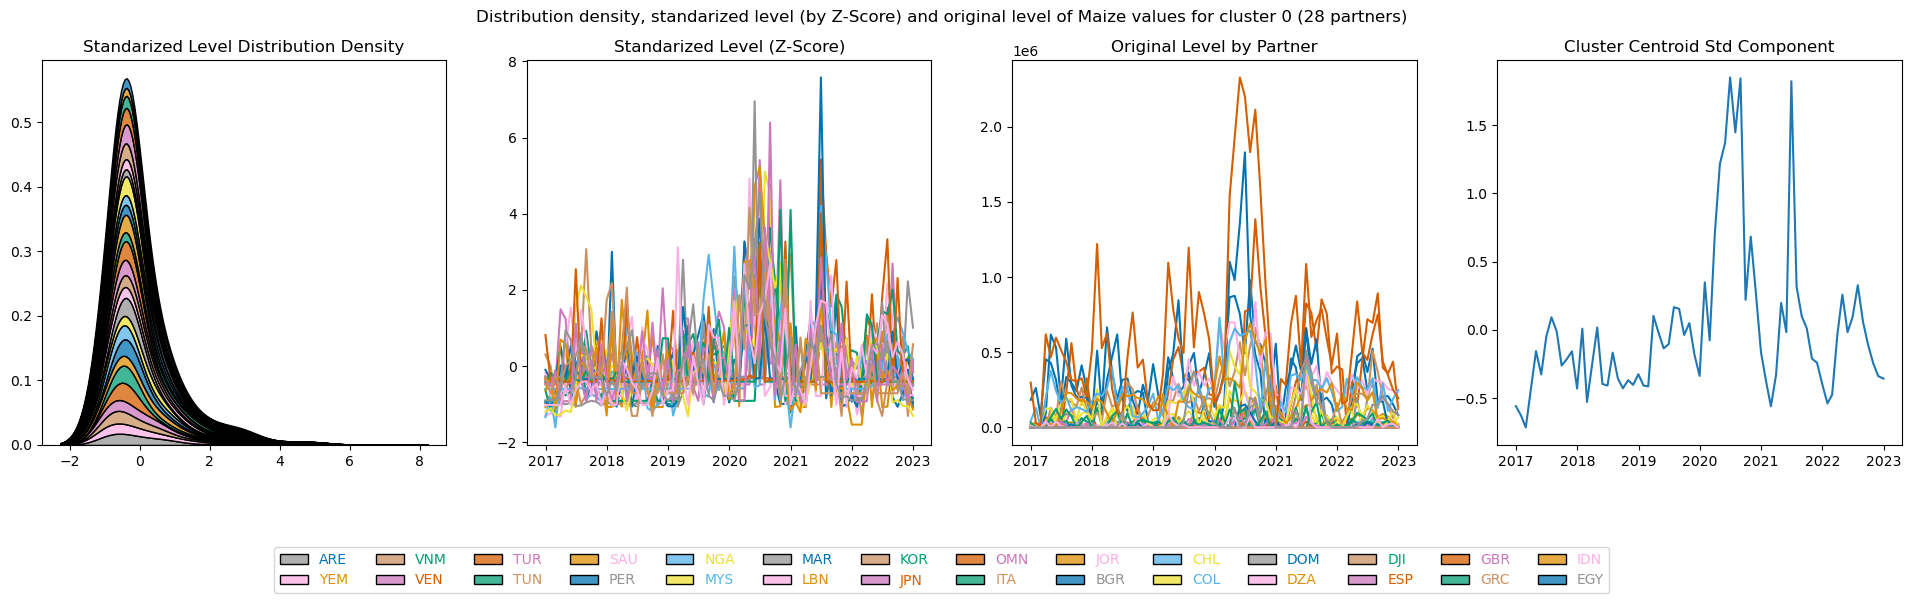

In [17]:
expID = '2_clusters'
clusterID = 0

summaryGrx(expID = expID, clusterID = clusterID)

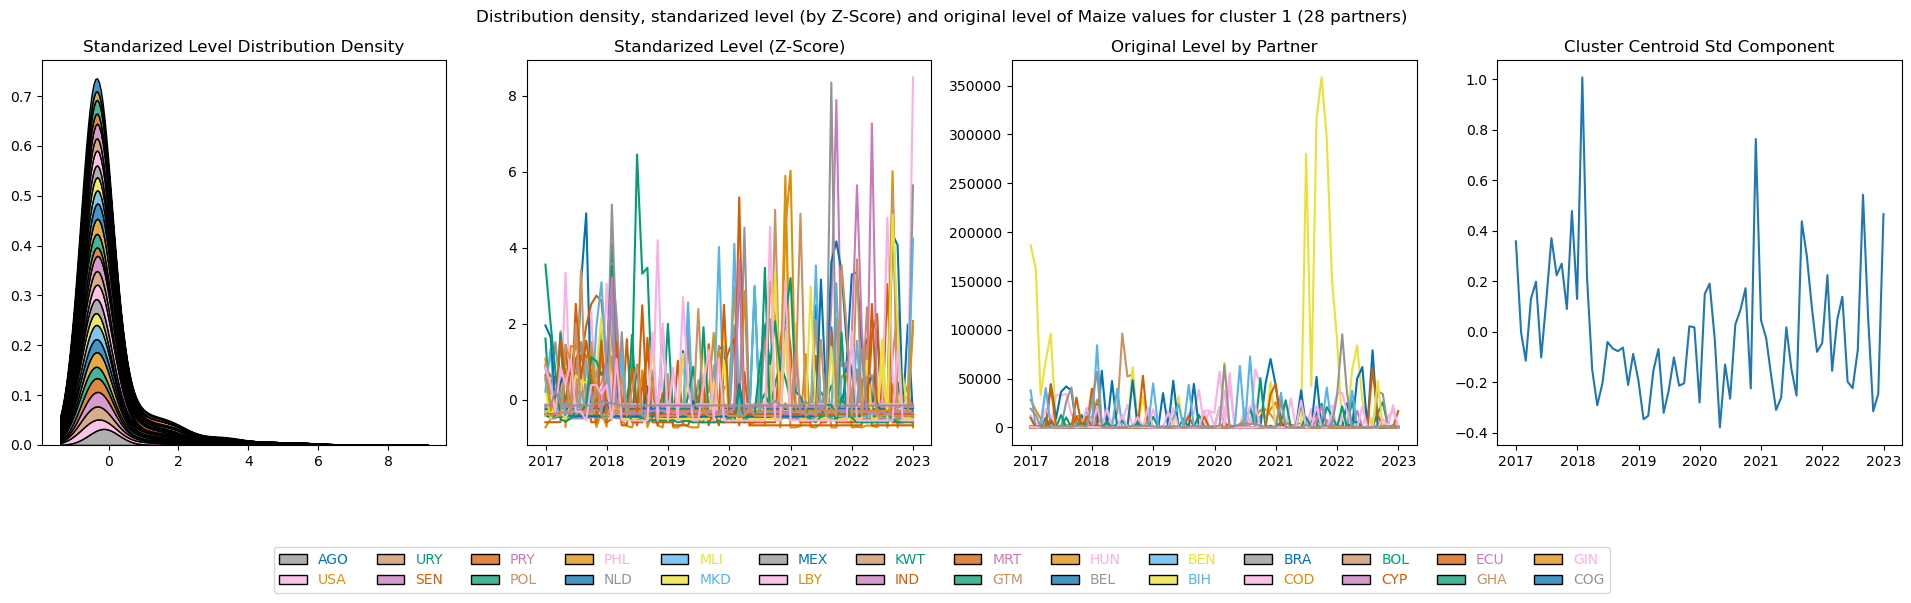

In [18]:
expID = '2_clusters'
clusterID = 1

summaryGrx(expID = expID, clusterID = clusterID)


The shapes of distribution are similar among members of each cluster, the major differences between clusters 0 and 1 are observed in the distribution tails, but it seems to be insufficiently well determined just using two clusters. Not every country has the same frequency of transactions and in the two clusters, the frequent and spot partners seem to be overlapped. 

Cluster 0 seems to contain a more similar series regarding the peak between 2020 and 2021. The final definition should be defined considering the business problem we want to solve, but it seems to be necessary to extend the number of clusters in any case to find insights.


**4 Clusters Test**

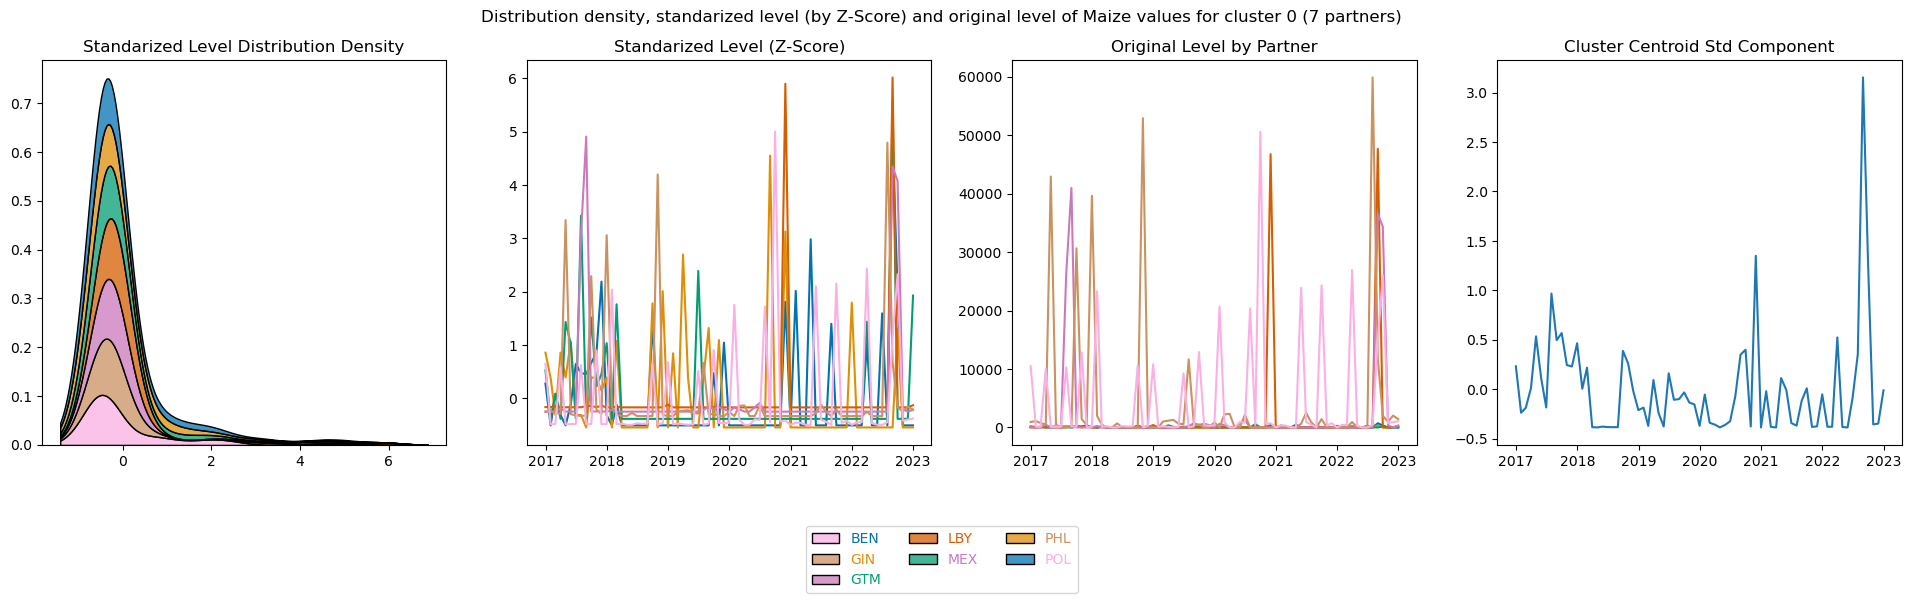

In [19]:
expID = '4_clusters'

summaryGrx(expID = expID, clusterID = 0)

Extending the analysis to 4 clusters seems to be more effective, now the shapes of distribution are more similar among series, and it seems to be a cluster with a certain degree of seasonality and spot partners. (This hypothesis should be analyzed deeper with the proper techniques for decomposing the series). 

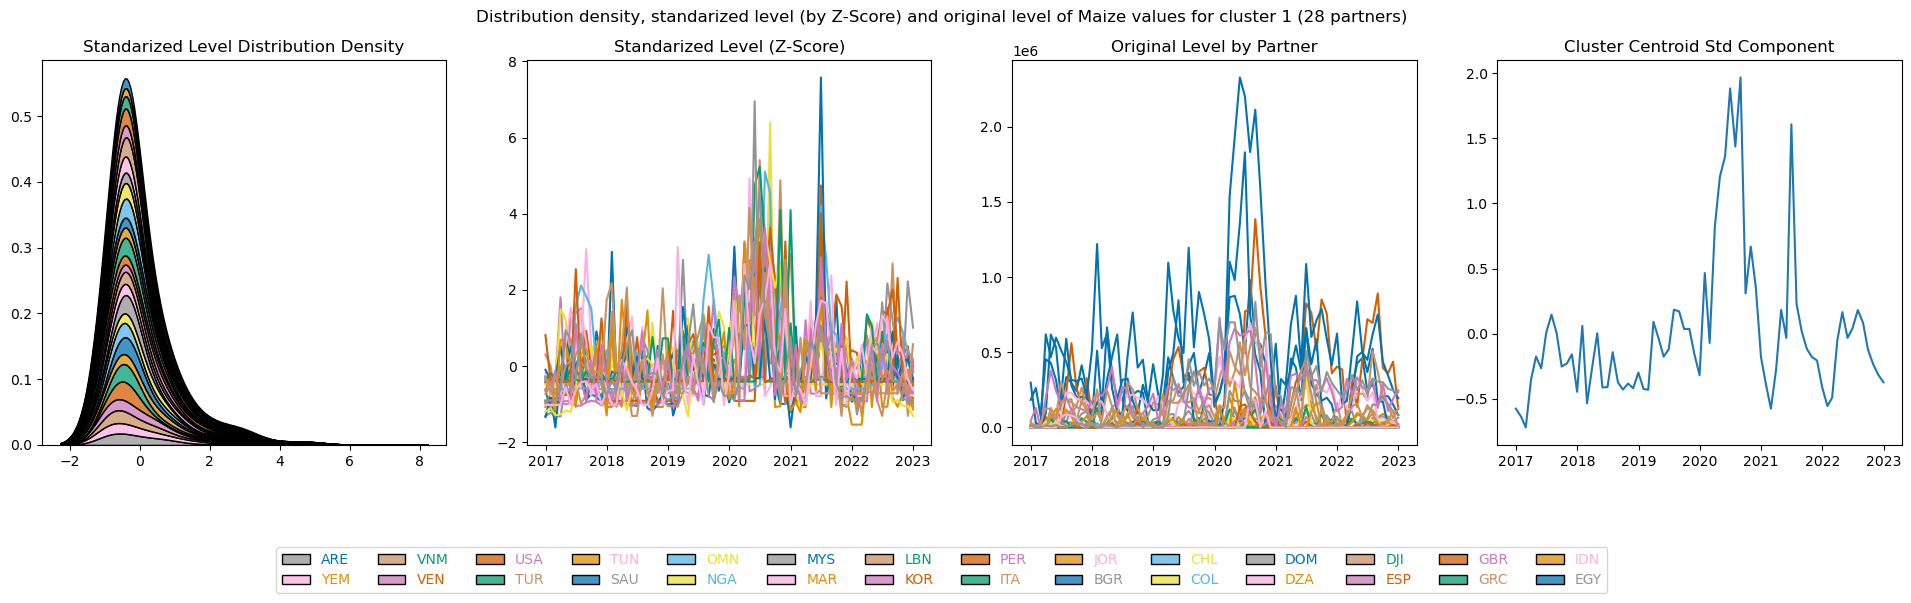

In [20]:
summaryGrx(expID = expID, clusterID = 1)

The cluster 1 contains partner with higher frequency, this cluster seems to contain the regular partners.

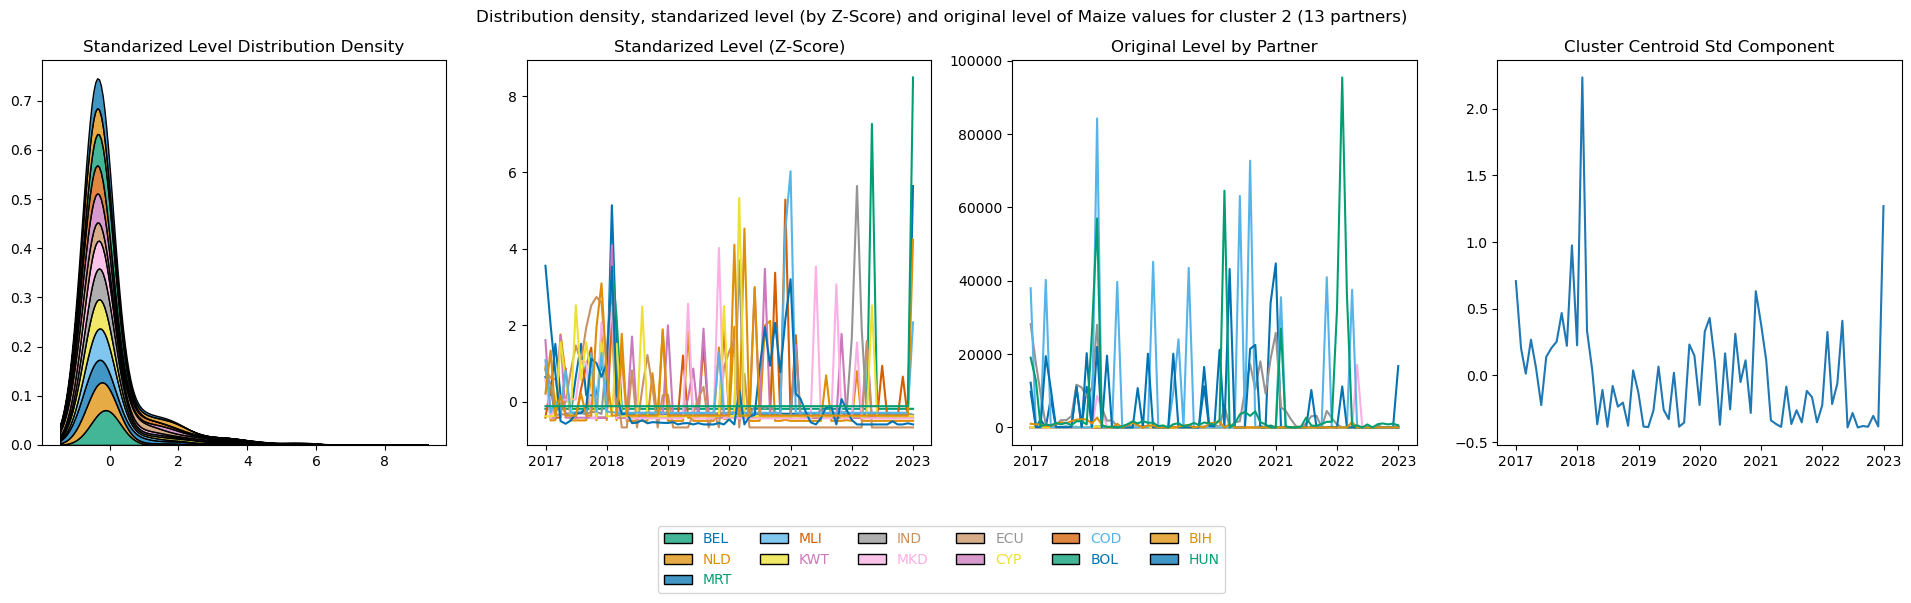

In [21]:
summaryGrx(expID = expID, clusterID = 2)

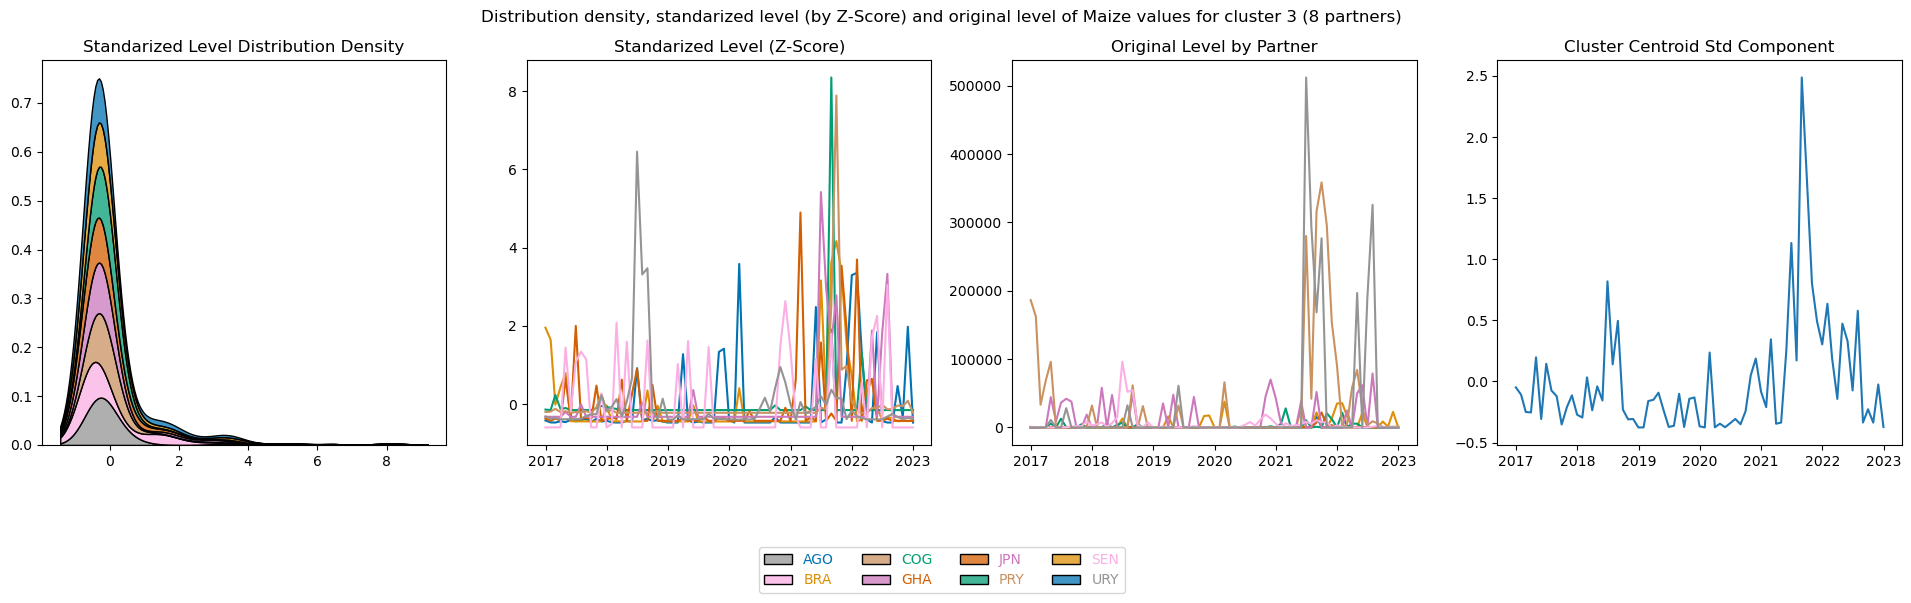

In [22]:
summaryGrx(expID = expID, clusterID = 3)

Clusters 2 and 3 contains also spot partners with different characteristics in the level values and peaks where cluster 3 has an important increase of activity after 2021, the opposite case with cluster 2.

The results will be exported to be presented in an exploratory dashboard with the other clustering experiments results.

### 05.00. EXPORT

In [23]:
selectedExperiment = '4_clusters'

df_export = df_base[selectedExperiment].reset_index().drop_duplicates().reset_index(drop = True).rename(columns = {selectedExperiment:'clusterByTWDs'})
df_export['cereal'] = cereal
df_export.to_csv(wd + f'/clustersExp02.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export.head()

,partnerCodeISO,clusterByTWDs,cereal
0,DZA,1,Maize
1,CHL,1,Maize
2,COL,1,Maize
3,COG,3,Maize
4,COD,2,Maize


In [24]:
df_export_centers = kmeansCenters[kmeansCenters['exp'] == selectedExperiment].drop(columns = ['exp','partners']).melt(id_vars = 'cluster').rename(columns = {'value':f'{flowColumn}_scaledCentroid'})
df_export_centers['cereal'] = cereal
df_export_centers.to_csv(wd + f'/clustersExp02_centers.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export_centers

,cluster,date,t_exp_scaledCentroid,cereal
0,0,2016-12-31,0.232885,Maize
1,1,2016-12-31,-0.574262,Maize
2,2,2016-12-31,0.706846,Maize
3,3,2016-12-31,-0.049067,Maize
4,0,2017-01-31,-0.236494,Maize
...,...,...,...,...
287,3,2022-11-30,-0.025314,Maize
288,0,2022-12-31,-0.010056,Maize
289,1,2022-12-31,-0.372483,Maize
290,2,2022-12-31,1.268867,Maize
